In [1]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

In [ ]:
import snscrape.modules.twitter as sntwitter
import pandas as pd

# query = "(from:elonmusk) until:2023-03-03 since:2023-01-01"
keyword = "Ramadhan"
num_of_tweets = 100

tweets_list = []

for i,tweet in enumerate(sntwitter.TwitterSearchScraper(keyword + ' lang:id').get_items()):
    if i>num_of_tweets:
        break
    
    print(f"Tweet {i+1}: {tweet.rawContent} berhasil diambil")
    tweets_list.append([
        tweet.date,
        tweet.id,
        tweet.user.username,
        tweet.likeCount,
        tweet.retweetCount,
        tweet.rawContent,
    ])
    
tweets_df = pd.DataFrame(tweets_list, columns=[
    'Datetime', 'Tweet Id', 'Username', 'Likes', 'Retweets', 'Text'
])

tweets_df.head()
tweets_df.to_csv('ramadhan_tweets.csv', index=False)

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

In [5]:
import urllib.request
import string
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import itertools
import pandas as pd
import pickle
from IPython.display import display, clear_output

In [ ]:
rawdf = pd.read_csv('ramadhan_tweets.csv')
rawdf.head() # show first 5 rows
tweet_text = rawdf['Text']
tweet_text

In [ ]:
# ------ Case Folding --------
'''
Case folding merupakan teknik yang digunakan untuk menghilangkan tanda baca dan mengubah teks
ke dalam bentuk lowercase. Sehingga yang diterima adalah huruf sesuai dengan abjad dimulai dari a sampai z,
selainnya dianggap sebagai delimiter
'''

tweet_text = tweet_text.str.lower()
print('Case Folding Result : \n')
print(tweet_text.head(5))
print('\n\n\n')

In [9]:
import string
import re #regex library

# import word_tokenize & FreqDist from NLTK
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

In [ ]:
# ------ Tokenizing ---------
"""
Tahapan ini merupakan proses pemotongan string masukan berdasarkan tiap kata yang menyusunnya.
"""

def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

tweet_text = tweet_text.apply(remove_tweet_special)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

tweet_text = tweet_text.apply(remove_number)

#remove punctuation (#, $, %, ^, &, *, (, ), _, +, {, }, |, :, <, >, ?, /, ~, `, =, [, ], \, ;, ', ", ,, ., !)
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

tweet_text = tweet_text.apply(remove_punctuation)

#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

tweet_text = tweet_text.apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

tweet_text = tweet_text.apply(remove_whitespace_multiple)

# remove single character
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

tweet_text = tweet_text.apply(remove_singl_char)

# NLTK word rokenize
def word_tokenize_wrapper(text):
    return word_tokenize(text)

rawdf['token'] = tweet_text.apply(word_tokenize_wrapper)

print('Tokenizing Result : \n')
print(rawdf['token'].head(5))
print('\n\n\n')

In [ ]:
from nltk.corpus import stopwords
"""
Kata yang dianggap tidak penting akan dihilangkan dalam proses ini. Tahapan ini termasuk ke dalam
proses filtering. Terdapat dua metode yang dapat digunakan yaitu stoplist untuk membuang kata kurang
penting, atau wordlist untuk menyimpan kata yang penting.
Contoh stopword adalah “yang”, “di”, “dan”, “dari” dan lain sebagainya
"""

# ----------------------- get stopword from NLTK stopword -------------------------------
# get stopword indonesia
list_stopwords = stopwords.words('indonesian')

# ---------------------------- manualy add stopword  ------------------------------------
# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja', 'n', 't',
                       'nyg', 'hehe', 'pen', 'u', 'nan', 'loh', 'rt',
                       '&amp', 'yah'])

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

rawdf['tweet_tokens_WSW'] = rawdf['token'].apply(stopwords_removal)
print(rawdf['tweet_tokens_WSW'].head(5))

In [ ]:
### --- Stemming --- ####
"""
proses mengembalikan suatu kata kepada bentuk dasarnya. Jika dalam Bahasa
Indonesia, proses stemming dapat digunakan untuk menghilangkan imbuhan yang menyertai kata dasarnya.
"""

# import Sastrawi package
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import swifter

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmed_wrapper(term):
    return stemmer.stem(term)

term_dict = {}

for document in rawdf['tweet_tokens_WSW']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmed_wrapper(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

rawdf['tweet_tokens_stemmed'] = rawdf['tweet_tokens_WSW'].swifter.apply(get_stemmed_term)
print(rawdf['tweet_tokens_stemmed'])

In [16]:
rawdf.to_csv("preprocessing_ramadhan.csv")

In [ ]:
# import StemmerFactory class
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

for i in tweet_text:
  # stemming process
  sentence = i
  output   = stemmer.stem(sentence)

  print(output)


In [18]:
import pandas as pd
import numpy as np

TWEET_DATA = pd.read_csv("preprocessing_ramadhan.csv", usecols=["tweet_tokens_stemmed"])
TWEET_DATA.columns = ["tweet"]

TWEET_DATA.head()

,tweet
0,"['jiwa', 'komunis', 'nampak', 'ummat', 'islam'..."
1,"['sebentar', 'ramadhan', 'latih', 'makan', 'si..."
2,"['preramadhan', 'checklist', 'taubat', 'doa', ..."
3,['tweetmu']
4,"['lia', 'plus', 'rawan', 'cedera', 'sis', 'rum..."


In [19]:
# convert list formated string to list
import ast

def convert_text_list(texts):
    texts = ast.literal_eval(texts)
    return [text for text in texts]

TWEET_DATA["tweet_list"] = TWEET_DATA["tweet"].apply(convert_text_list)
TWEET_DATA.head()


,tweet,tweet_list
0,"['jiwa', 'komunis', 'nampak', 'ummat', 'islam'...","[jiwa, komunis, nampak, ummat, islam, dekat, p..."
1,"['sebentar', 'ramadhan', 'latih', 'makan', 'si...","[sebentar, ramadhan, latih, makan, siang]"
2,"['preramadhan', 'checklist', 'taubat', 'doa', ...","[preramadhan, checklist, taubat, doa, jumpa, r..."
3,['tweetmu'],[tweetmu]
4,"['lia', 'plus', 'rawan', 'cedera', 'sis', 'rum...","[lia, plus, rawan, cedera, sis, rumor, main, a..."


In [24]:
def calc_TF(document):
    # Counts the number of times the word appears in review
    TF_dict = {}
    for term in document:
        if term in TF_dict:
            TF_dict[term] += 1
        else:
            TF_dict[term] = 1
    # Computes tf for each word
    for term in TF_dict:
        # rumus = frekuensi kemunculan term / jumlah term pada dokumen
        TF_dict[term] = TF_dict[term] / len(document)
    return TF_dict

TWEET_DATA["TF_dict"] = TWEET_DATA['tweet_list'].apply(calc_TF)
# TWEET_DATA["TF_dict"].head()
TWEET_DATA["TF_dict"][0]


{'jiwa': 0.06666666666666667,
 'komunis': 0.06666666666666667,
 'nampak': 0.06666666666666667,
 'ummat': 0.06666666666666667,
 'islam': 0.06666666666666667,
 'dekat': 0.06666666666666667,
 'puasa': 0.06666666666666667,
 'ramadhan': 0.06666666666666667,
 'covid': 0.06666666666666667,
 'jg': 0.06666666666666667,
 'dtg': 0.06666666666666667,
 'wkt': 0.06666666666666667,
 'hhhhhhh': 0.06666666666666667,
 'komplak': 0.06666666666666667,
 'lo': 0.06666666666666667}

In [25]:
index = 0

print('%20s' % "term", "\t", "TF\n")
for key in TWEET_DATA["TF_dict"][index]:
    print('%20s' % key, "\t", TWEET_DATA["TF_dict"][index][key])

                term 	 TF

                jiwa 	 0.06666666666666667
             komunis 	 0.06666666666666667
              nampak 	 0.06666666666666667
               ummat 	 0.06666666666666667
               islam 	 0.06666666666666667
               dekat 	 0.06666666666666667
               puasa 	 0.06666666666666667
            ramadhan 	 0.06666666666666667
               covid 	 0.06666666666666667
                  jg 	 0.06666666666666667
                 dtg 	 0.06666666666666667
                 wkt 	 0.06666666666666667
             hhhhhhh 	 0.06666666666666667
             komplak 	 0.06666666666666667
                  lo 	 0.06666666666666667


In [26]:
def calc_DF(tfDict):
    count_DF = {}
    # Run through each document's tf dictionary and increment countDict's (term, doc) pair
    for document in tfDict:
        for term in document:
            if term in count_DF:
                count_DF[term] += 1
            else:
                count_DF[term] = 1
    return count_DF

DF = calc_DF(TWEET_DATA["TF_dict"])

In [27]:
n_document = len(TWEET_DATA)

def calc_IDF(__n_document, __DF):
    IDF_Dict = {}
    for term in __DF:
        IDF_Dict[term] = np.log(__n_document / (__DF[term] + 1))
    return IDF_Dict

#Stores the idf dictionary
IDF = calc_IDF(n_document, DF)

In [28]:
#calc TF-IDF
def calc_TF_IDF(TF):
    TF_IDF_Dict = {}
    #For each word in the review, we multiply its tf and its idf.
    for key in TF:
        TF_IDF_Dict[key] = TF[key] * IDF[key]
    return TF_IDF_Dict

#Stores the TF-IDF Series
TWEET_DATA["TF-IDF_dict"] = TWEET_DATA["TF_dict"].apply(calc_TF_IDF)

In [29]:
# Check TF-IDF result
index = 0

print('%20s' % "term", "\t", '%10s' % "TF", "\t", '%20s' % "TF-IDF\n")
for key in TWEET_DATA["TF-IDF_dict"][index]:
    print('%20s' % key, "\t", TWEET_DATA["TF_dict"][index][key] ,"\t" , TWEET_DATA["TF-IDF_dict"][index][key])


                term 	         TF 	              TF-IDF

                jiwa 	 0.06666666666666667 	 0.2614648890854209
             komunis 	 0.06666666666666667 	 0.2614648890854209
              nampak 	 0.06666666666666667 	 0.2614648890854209
               ummat 	 0.06666666666666667 	 0.2614648890854209
               islam 	 0.06666666666666667 	 0.23443388187821
               dekat 	 0.06666666666666667 	 0.23443388187821
               puasa 	 0.06666666666666667 	 0.18822406984088028
            ramadhan 	 0.06666666666666667 	 0.021644071712857885
               covid 	 0.06666666666666667 	 0.1779473578523964
                  jg 	 0.06666666666666667 	 0.23443388187821
                 dtg 	 0.06666666666666667 	 0.2614648890854209
                 wkt 	 0.06666666666666667 	 0.2614648890854209
             hhhhhhh 	 0.06666666666666667 	 0.2614648890854209
             komplak 	 0.06666666666666667 	 0.2614648890854209
                  lo 	 0.06666666666666667 	 0.261

In [30]:
# sort descending by value for DF dictionary
sorted_DF = sorted(DF.items(), key=lambda kv: kv[1], reverse=True)[:50]

# Create a list of unique words from sorted dictionay `sorted_DF`
unique_term = [item[0] for item in sorted_DF]

def calc_TF_IDF_Vec(__TF_IDF_Dict):
    TF_IDF_vector = [0.0] * len(unique_term)

    # For each unique word, if it is in the review, store its TF-IDF value.
    for i, term in enumerate(unique_term):
        if term in __TF_IDF_Dict:
            TF_IDF_vector[i] = __TF_IDF_Dict[term]
    return TF_IDF_vector

TWEET_DATA["TF_IDF_Vec"] = TWEET_DATA["TF-IDF_dict"].apply(calc_TF_IDF_Vec)

print("print first row matrix TF_IDF_Vec Series\n")
print(TWEET_DATA["TF_IDF_Vec"][0])

print("\nmatrix size : ", len(TWEET_DATA["TF_IDF_Vec"][0]))

print first row matrix TF_IDF_Vec Series

[0.021644071712857885, 0.0, 0.0, 0.0, 0.1779473578523964, 0.0, 0.0, 0.18822406984088028, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.23443388187821, 0.23443388187821, 0.23443388187821, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

matrix size :  50


In [31]:
# Convert Series to List
TF_IDF_Vec_List = np.array(TWEET_DATA["TF_IDF_Vec"].to_list())

# Sum element vector in axis=0
sums = TF_IDF_Vec_List.sum(axis=0)

data = []

for col, term in enumerate(unique_term):
    data.append((term, sums[col]))

ranking = pd.DataFrame(data, columns=['term', 'rank'])
ranking.sort_values('rank', ascending=False)

,term,rank
5,makan,4.296687
0,ramadhan,3.483121
1,ibadah,2.469587
26,udah,2.367806
3,aman,2.287994
33,moga,2.272137
30,pasti,2.111156
2,sambut,2.092878
4,covid,2.084526
13,darurat,2.016686


In [32]:
ranking.to_csv("ranking_ramadhan.csv")

Matplotlib is building the font cache; this may take a moment.


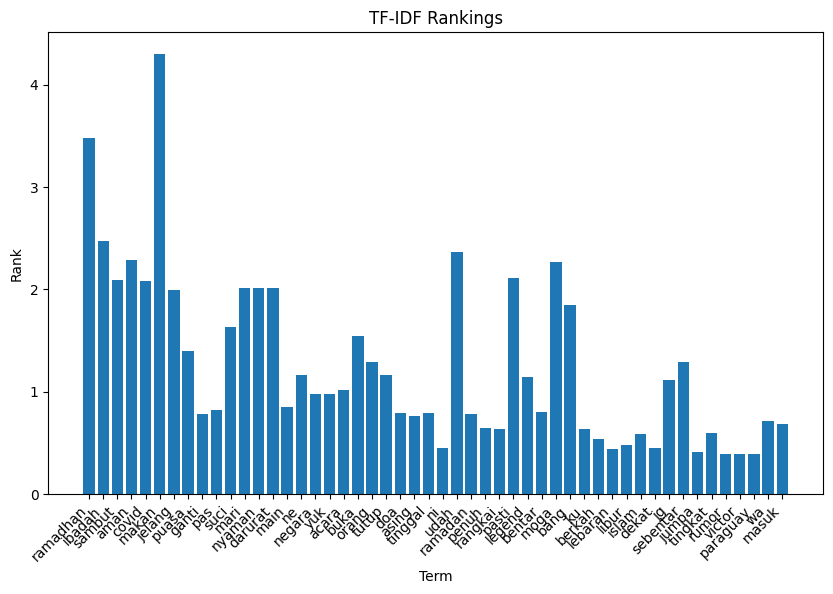

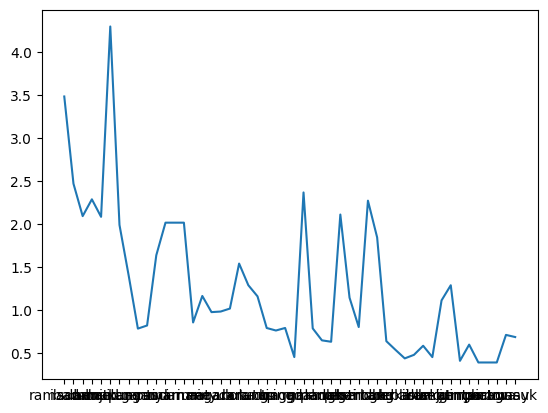

In [34]:
# visualisasi data
import matplotlib.pyplot as plt

# plot data
terms = ranking['term']
ranks = ranking['rank']

plt.figure(figsize=(10, 6))
plt.bar(terms, ranks)
plt.title("TF-IDF Rankings")
plt.xlabel("Term")
plt.ylabel("Rank")
plt.xticks(rotation=45, ha='right')
plt.show()
plt.plot(ranking['term'], ranking['rank'])


In [ ]:
# next step?

"""
Information Retrieval (IR): Hasil perengkingan dapat digunakan untuk mengurutkan dokumen dalam mesin pencari, sehingga hasil pencarian yang diberikan lebih relevan dan sesuai dengan kata kunci yang diinputkan oleh pengguna.
Text Classification: Hasil perengkingan dapat digunakan sebagai fitur dalam model klasifikasi teks, seperti Naive Bayes, SVM, atau Random Forest. Contohnya, kata-kata dengan nilai TF-IDF tertinggi dapat digunakan sebagai fitur penting dalam klasifikasi topik atau sentimen.
Keyword Extraction: Kata-kata dengan nilai TF-IDF tertinggi dapat digunakan sebagai fitur penting untuk mengekstrak kata kunci dari dokumen. Contohnya, kata-kata yang memiliki nilai TF-IDF yang tinggi dalam dokumen yang berkaitan dengan suatu topik dapat dianggap sebagai kata kunci penting untuk topik tersebut.
Text Summarization: Seperti yang telah kita bahas sebelumnya, hasil perengkingan dapat digunakan untuk membuat ringkasan teks yang relevan dan representatif. Dokumen atau kalimat dengan nilai TF-IDF tertinggi dapat dipilih sebagai bagian dari ringkasan.
Language Modeling: Hasil perengkingan dapat digunakan sebagai fitur dalam model bahasa yang mengukur probabilitas kemunculan kata dalam teks. Kata-kata dengan nilai TF-IDF yang tinggi dapat dianggap sebagai kata-kata yang penting dalam model tersebut.
"""